## Don't mind me making odd figures for a poster
Adapted from 241028_midterm_figures

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/glade/u/home/jjeffree/ensemble-analogue-predictability/')
import predictability_tools as pt

import cmcrameri.cm as cmc
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

In [3]:
plt.figure()
plt.rcParams['font.size'] = 24

<Figure size 640x480 with 0 Axes>

In [28]:
client.close()

In [4]:
from dask.distributed import Client
client = Client(threads_per_worker=1,memory_limit=0)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/jjeffree/another_node/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/jjeffree/another_node/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37639,Workers: 4
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/jjeffree/another_node/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:33823,Total threads: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/jjeffree/another_node/proxy/42873/status,Memory: 0 B
Nanny: tcp://127.0.0.1:36185,


## FUnctions

In [5]:
def incremental_sailboat2(skill,
                    N = 40*90*7,
                    start_mask = ('30P','30P','30P'),
                    later_mask=('30P30A','30P30I','60P'),
                    skill_type='corr',
                    vlim=(-0.075,0.075),
             fig = None,
             axs = None,
             cb_axs=None,

    ):
    assert not(0 in skill.init_month), 'Month should have coordinates'
    if skill_type=='corr':
        diff_func = lambda x,y: y**2-x**2
        cmap = 'BrBG'
        cbar_extend = 'both'
        def stat_sig(r,r1):
            S = np.sqrt(1/(N-3))

            z = (np.arctanh(r1)-np.arctanh(r))/S
            
            # stat_sig = xr.ones_like(z).where(np.abs(z)>1.96)
            # if np.any(~np.isnan(stat_sig)) and np.any(np.isnan(stat_sig)):
            #     pt.plot.add_iso_line(plt.gca(), stat_sig.roll(init_month=-4).T, 0.01,x_shift = 5, y_shift = 0,linekwargs={'colors':'grey','lw':0.8,'linestyle':'dotted'}) #I think xshift is 1st month???

            stat_sig = xr.ones_like(z).where(np.abs(z)>2.58)
            if np.any(~np.isnan(stat_sig)) and np.any(np.isnan(stat_sig)):
                pt.plot.add_iso_line(plt.gca(), stat_sig.roll(init_month=-4).T, 0.01,x_shift = 5, y_shift = 0,linekwargs={'colors':'grey','lw':1,}) #I think xshift is 1st month???
        clabel0 = 'r'
        clabel = r'$\Delta$r$^2$'

    elif skill_type=='mse':
        diff_func = lambda x,y: ((y-x)/x)*100
        cmap = 'BrBG_r'
        cbar_extend = 'both'

        def stat_sig(r,r1):
                F = r1/r

                p_good = scipy.stats.f.cdf(r1/r,N-2,N-2)
                p_bad = scipy.stats.f.cdf(r/r1,N-2,N-2)
                p = np.min((p_good,p_bad),axis=0)
                
                stat_sig = xr.ones_like(F).where(p<0.01)
                if np.any(~np.isnan(stat_sig)) and np.any(np.isnan(stat_sig)):
                    pt.plot.add_iso_line(plt.gca(), stat_sig.roll(init_month=-4).T, 0.01,x_shift = 5, y_shift = 0,linekwargs={'colors':'grey','lw':0.8,})#'linestyle':'dotted' #I think xshift is 1st month???

        clabel0 = 'MSE'
        clabel = '% MSE change'
    elif skill_type=='first_only':
        diff_func = lambda x,y: x**2
        cmap = 'BuGn'
        cbar_extend = 'max'

        def stat_sig(r,r1):
            return None
        clabel0 = 'r'
        clabel = r'$\Delta$r$^2$'
    else:
        assert False, 'need a skill type'

    if fig is None:
        assert axs is None, 'Either pass both axs and fig or neither'
        fig, axs = plt.subplots(1,len(later_mask)+1,figsize=((len(later_mask)+1)*4,8),
                               sharex=True,sharey=True)
    elif axs is None:
        assert False, 'Either pass both axs and fig or neither'
        
    # if cb_axs is None:
    #     cb_axs=axs

    assert len(later_mask) == len(start_mask), 'later and start mask must be paired'
    for ax_i in range(len(later_mask)):
        plt.sca(axs)

        r = skill.sel(mask=start_mask[ax_i])
        r1 = skill.sel(mask=later_mask[ax_i])

        scatter = plt.pcolormesh(((r.init_month+r.L*0-5)%12+5).roll(init_month=-4),
            (r.init_month*0+r.L).roll(init_month=-4),
            diff_func(r,r1).roll(init_month=-4),
            cmap=cmap,
                                 #marker='s',s=100,
                                 vmin=vlim[0],vmax=vlim[1])
        stat_sig(r,r1)

        # plt.xticks((13,7,),('Jan','Jul',),)#size=32)
        # #plt.title(start_mask[ax_i]+' -> '+later_mask[ax_i])
        
        axs.yaxis.set_tick_params(size=30,width=2,color='grey')
        axs.xaxis.set_tick_params(size=15,width=2,color='grey')

    if not(cb_axs is None):
        cbar = fig.colorbar(scatter, 
                            ax=cb_axs,
                            orientation='horizontal', 
                            fraction=1,
                             extend=cbar_extend,
                            pad=0.1,
                            aspect=60,
                           )
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label(clabel, fontsize=20)
        

    return axs

In [6]:
def plot_bunch_of_models(r,start_mask,later_mask,models,titlesize=24,**kwargs):
    n=len(models)
    fig, axs = plt.subplots(len(start_mask)+1,n,figsize=(n*4,12*(len(start_mask)+0.2)*1.1),
                            sharey=True,gridspec_kw={'height_ratios':[1]*len(start_mask)+[0.2]}
                           )
    # if len(start_mask)==1:
    #     axs = np.expand_dims(axs,0)
    #     # start_mask=[start_mask]
    #     # later_mask=[later_mask]
    plt.subplots_adjust(wspace=0.15)
    #plt.subplots_adjust(bottom=0.35)

        # mask_delta = pt.mask_dict[start_mask].astype(int)
        # mask_delta += pt.mask_dict[later_mask].astype(int)*2
        
        # plt.sca(axs[0])
        # plt.pcolormesh(mask_delta.lon,mask_delta.lat,mask_delta,cmap='PuBu')
        # plt.pcolormesh(mask_delta.lon,mask_delta.lat,pt.mask_definitions.ocean_mask.where(~pt.mask_definitions.ocean_mask),cmap='Greys',vmin=-1,vmax=2)
        # axs[0].set_axis_off()
        # plt.ylim(-270,270)
    for mi in range(len(start_mask)):
        for i,model_name in enumerate(models):
            axs[len(start_mask),i].axis('off')
            if (i==0) and (mi==0):
                cb_axs=axs[len(start_mask),:]
            else:
                cb_axs=None#(phantom_ax,phantom_ax)
            incremental_sailboat2(r[model_name],N=91*pt.n_ensemble_members[model_name]*((pt.n_ensemble_members[model_name])//5-1),
                             start_mask=[start_mask[mi]],
                             later_mask=[later_mask[mi]],
                             fig=fig,axs=axs[mi,i],cb_axs=cb_axs,**kwargs)
    
            axs[mi,0].set_yticks([0,12,24,36],[0,12,24,36],)#fontsize=20)
            axs[mi,-1].tick_params(right=True,labelright=True)
            axs[mi,-1].set_yticks([0,12,24,36],[0,12,24,36],)#fontsize=20)
            
            # old_title = axs[0,i+1].get_title()
            if i%2==0:
                updown = ('','\n|')
            else:
                updown = ('\n','')
            if model_name == 'CESM2-LE':
                axs[mi,i].set_title(updown[0]+'CESM2'+updown[1],size=titlesize,pad=20)
            else:
                axs[mi,i].set_title(updown[0]+model_name.split('_')[0]+updown[1],size=titlesize,pad=20)
            axs[mi,0].set_ylabel('Lead time (months)',size=42)
            #axs[len(start_mask)-1,i].set_xlabel('initialisation',size=30,labelpad=25)
            
            axs[mi,i].set_xticks([7,10,13,16],['','','',''],size=30,rotation=45)
            axs[-2,i].set_xticks([7,10,13,16],['Jul','Oct','Jan','Apr'],size=36,rotation=90)

            for inc in (0,12,24,):
                axs[mi,i].plot((4.5,16.5),np.array((11.5,-0.5))+inc,c='#666666',linestyle =(0, (7, 10)))
    return fig, axs

## plots

In [30]:
# def hex_to_rgb(hex_color):
#     return np.array(mcolors.hex2color(hex_color))

# def generate_colors(start_color, end_color, n=10):
#     # Convert hex to RGB if needed
#     if isinstance(start_color, str):
#         start_color = hex_to_rgb(start_color)
#     if isinstance(end_color, str):
#         end_color = hex_to_rgb(end_color)
    
#     return np.linspace(start_color, end_color, n)

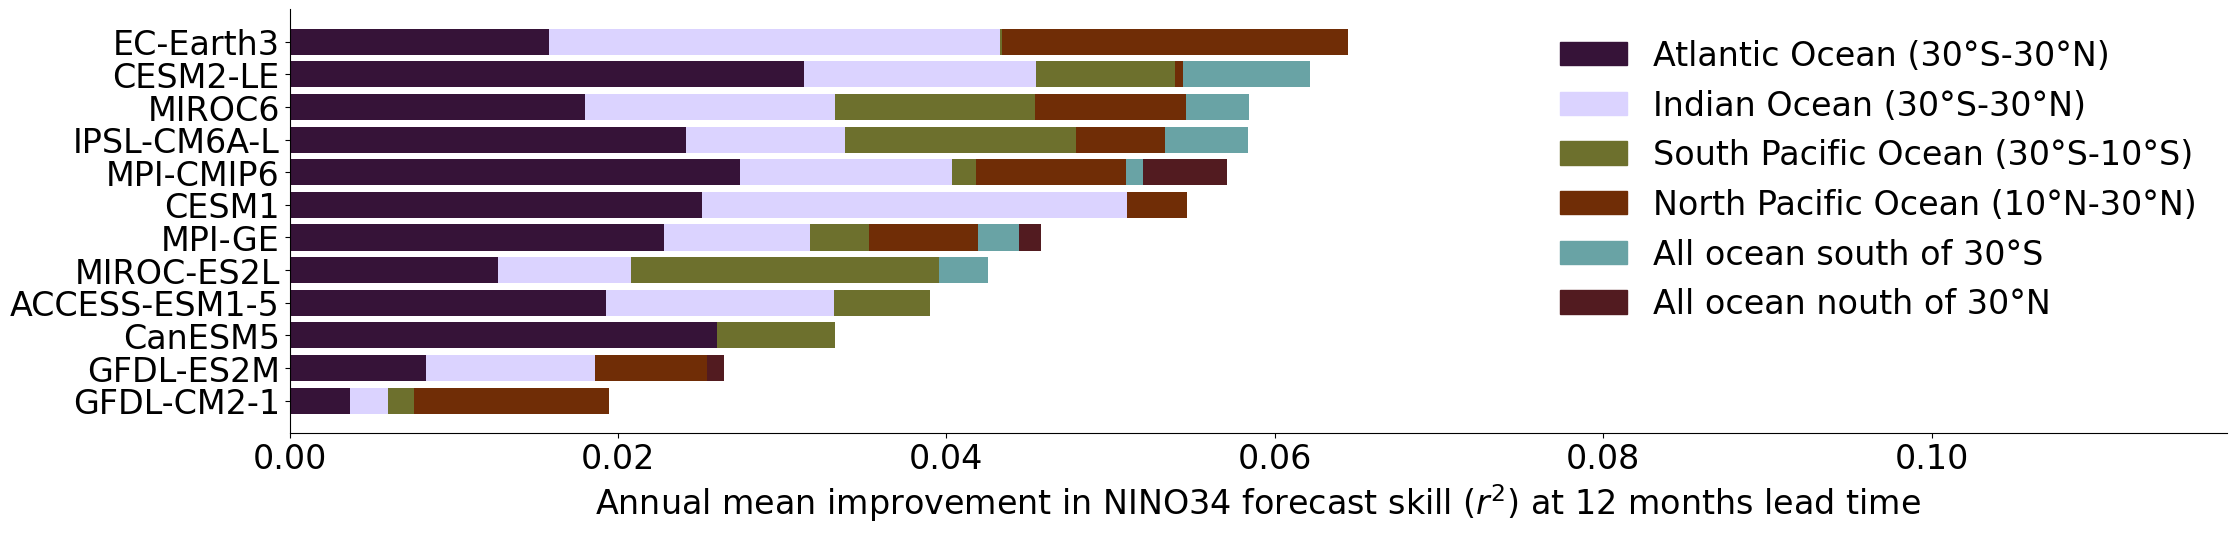

In [9]:
plt.rcParams['font.size'] = 24
plt.figure(figsize=(25,5.5))

r = xr.open_mfdataset(['/glade/work/jjeffree/results/area_corr/multiindex/NINO34_r/'+m+'.nc' 
                       for m in ('10P','10P30A','10P30I','10-30P','30-10P','10P30S','10P30N')]).load()
r_pace = xr.open_mfdataset(['/glade/work/jjeffree/results/area_corr/multiindex/NINO34_r/pacemaker_'+m+'.nc' 
                       for m in ('10P','10P30A','10P30I','10-30P','30-10P','10P30S','10P30N')]).load()

colors = cmc.glasgowS.colors#np.array(generate_colors('#321536','#69617c',6))[np.array((0,3,1,4,2,5))]#cmc.Acton10.colors
#prev_heights = None
model_keys = np.array(([k for k in r.keys()]+[k for k in r_pace.keys()]))[np.array([11,  3,  2,  0,  5,  8,  9,  7,  4,  6,  1, 10])]
prev_heights = {k:0 for k in model_keys}
for ci,m2 in enumerate(('10P30A','10P30I','30-10P','10-30P','10P30S','10P30N')):
    peak = ((r.sel(mask=m2)**2-r.sel(mask='10P')**2)).mean('init_month').sel(L=12)
    for k in r_pace:
        peak[k] = ((r_pace[k].sel(mask=m2)**2-r_pace[k].sel(mask='10P')**2)).mean('init_month').sel(L=12)

    for i, mod in enumerate(model_keys):
        if peak[mod]>0:
            plt.barh(i,peak[mod],left=prev_heights[mod],color=colors[ci],)
            prev_heights[mod] += peak[mod]

plt.yticks(np.arange(12),[k.split('_')[0] for k in model_keys])
plt.xlabel('Annual mean improvement in NINO34 forecast skill ($r^2$) at 12 months lead time')
plt.xlim(0,0.118)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
labels = ['Atlantic Ocean (30°S-30°N)', 'Indian Ocean (30°S-30°N)', 'South Pacific Ocean (30°S-10°S)','North Pacific Ocean (10°N-30°N)',  'All ocean south of 30°S','All ocean nouth of 30°N', ]
plt.gca().legend(handles = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(6)],frameon=False)
plt.savefig('figures/modelsbar.pdf',facecolor='None',transparent='True',bbox_inches='tight',pad_inches=1)


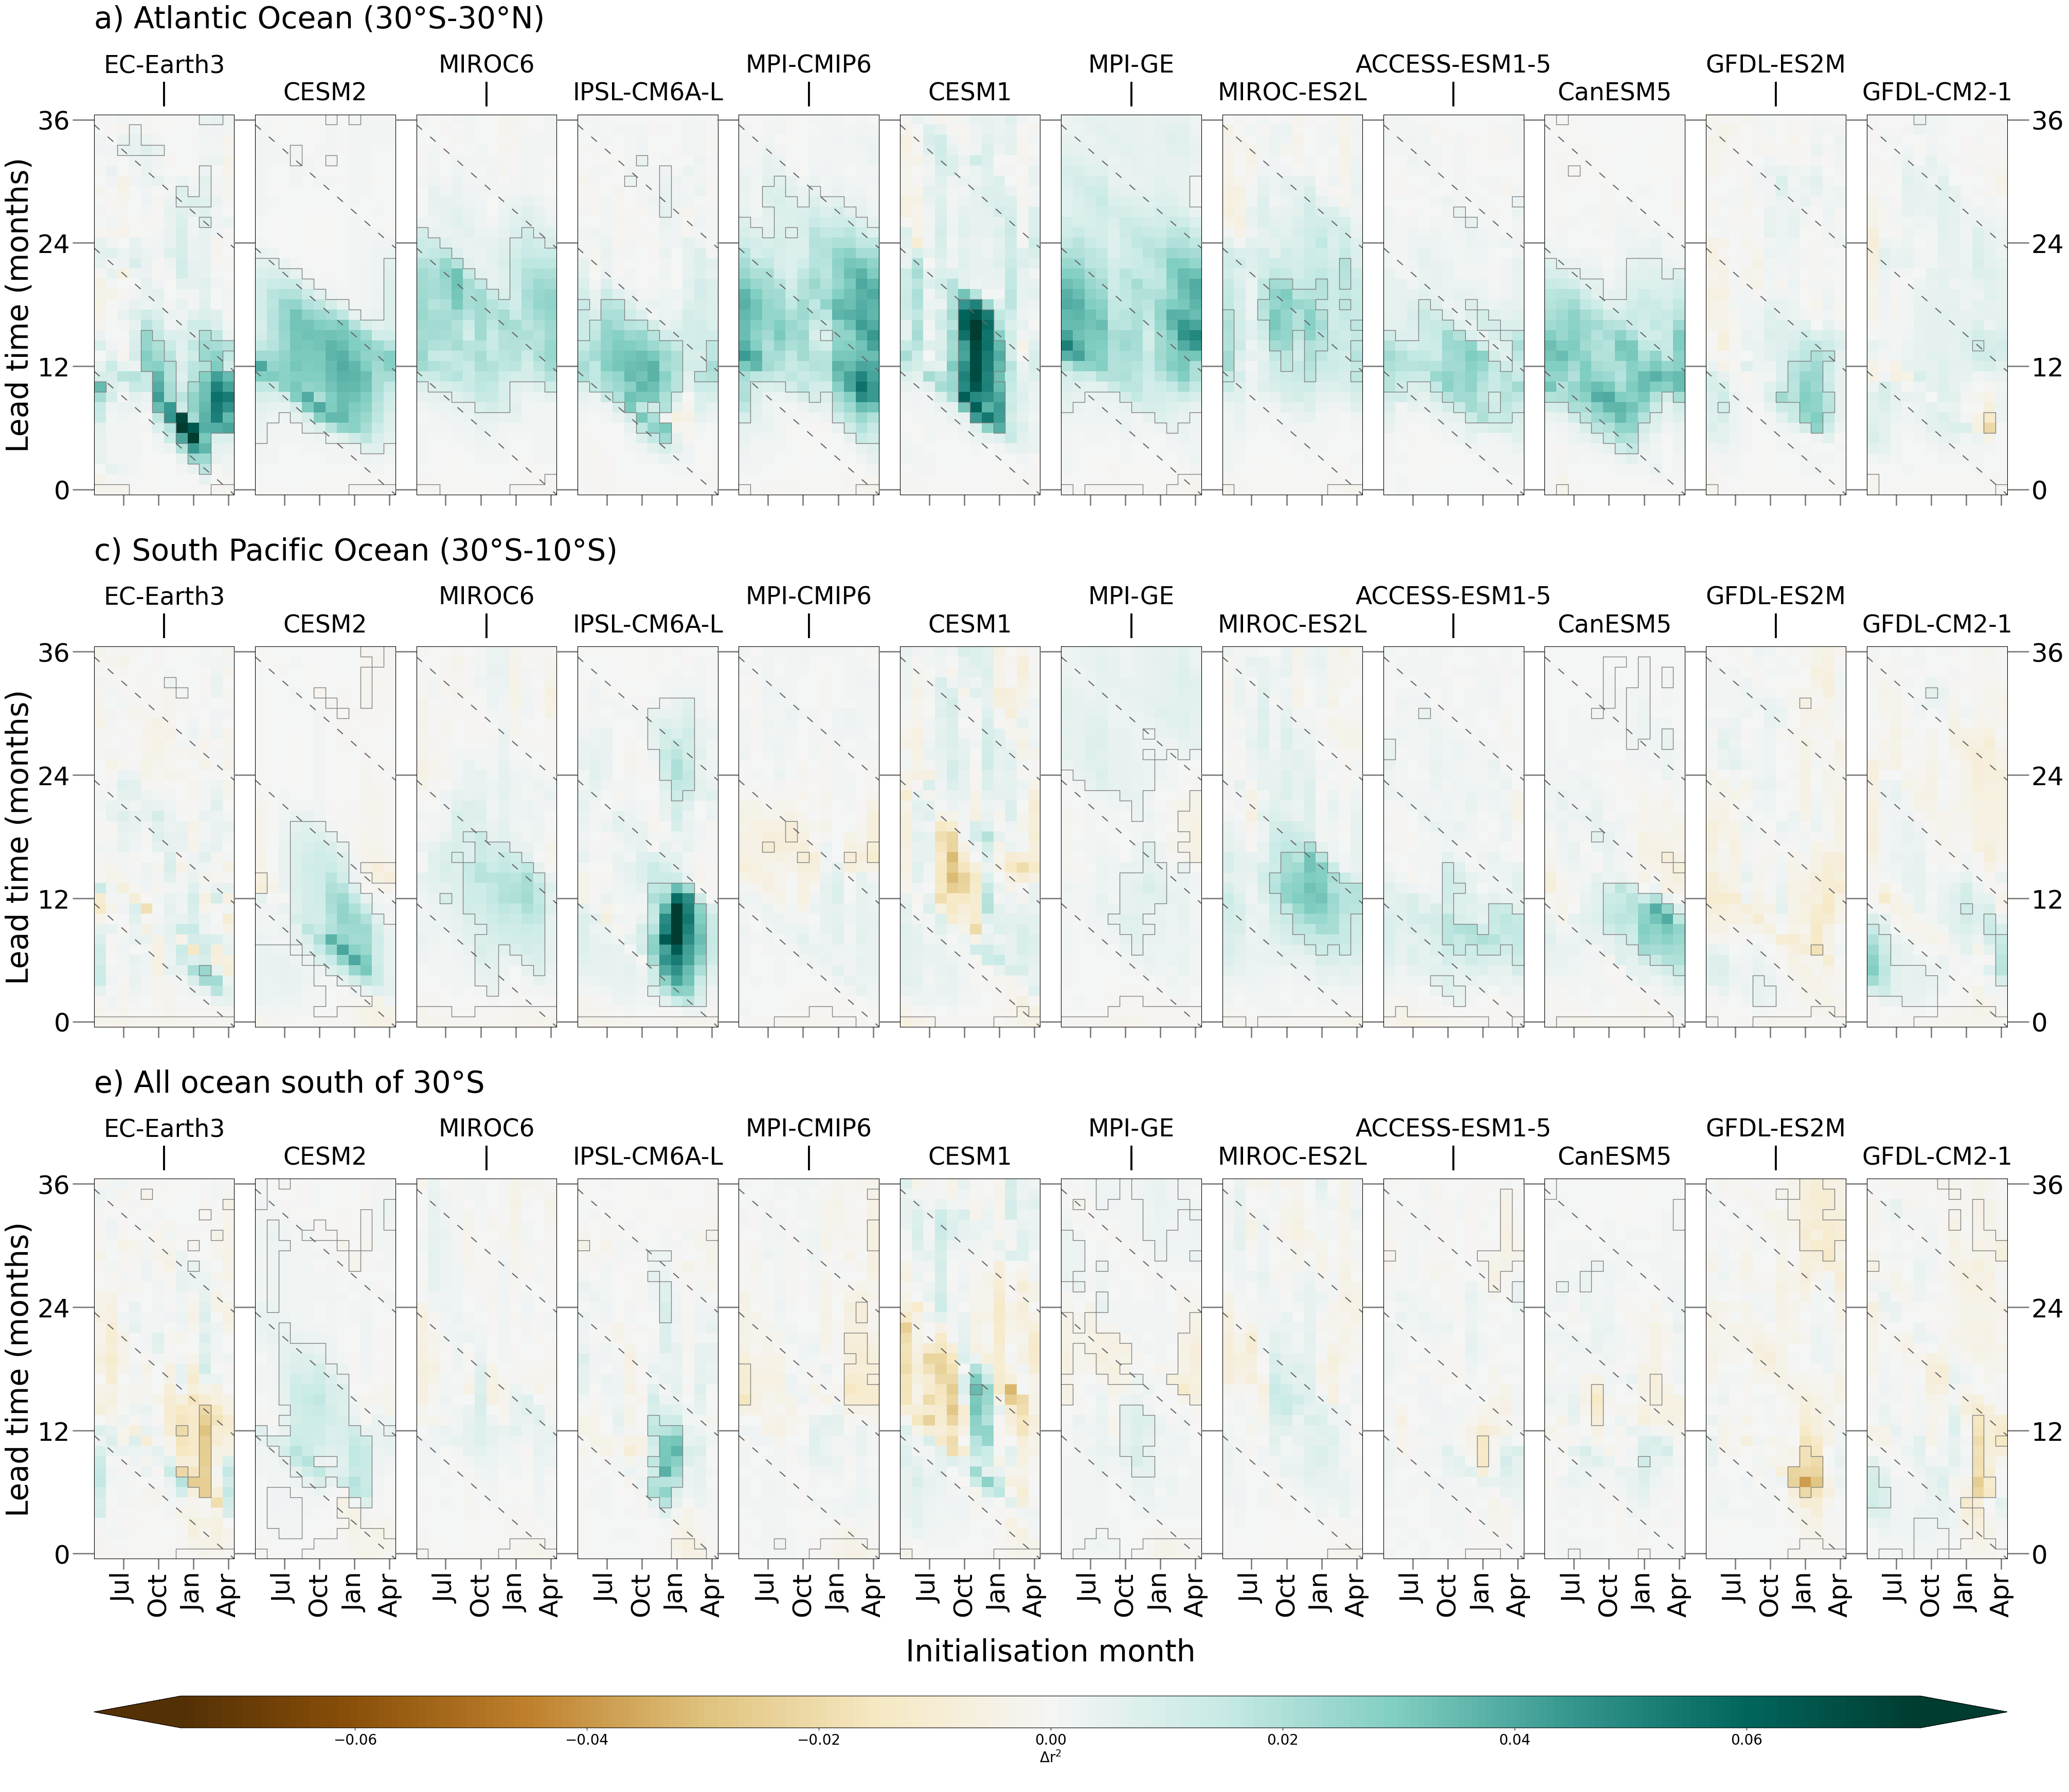

In [10]:
plt.rcParams['font.size'] = 36
r_smile = xr.open_mfdataset(['/glade/work/jjeffree/results/area_corr/multiindex/NINO34_r/'+m+'.nc' 
                       for m in ('10P','10P30A','10P30I','10-30P','30-10P','10P30S','10P30N')]).load()
r_pace = xr.open_mfdataset(['/glade/work/jjeffree/results/area_corr/multiindex/NINO34_r/pacemaker_'+m+'.nc' 
                       for m in ('10P','10P30A','10P30I','10-30P','30-10P','10P30S','10P30N')]).load()

r = xr.merge((r_smile,r_pace))
fig, axs = plot_bunch_of_models(r,
                     start_mask = ('10P','10P','10P'),
                     later_mask = ('10P30A','30-10P','10P30S'),
                     models=model_keys[::-1],
                               titlesize=34)
plt.subplots_adjust(hspace=0.5)

fig.text(axs[0,0].get_position().x0,axs[0,0].get_position().y1+0.037,"a) Atlantic Ocean (30°S-30°N)",size=42,ha='left',va='bottom')
fig.text(axs[1,0].get_position().x0,axs[1,0].get_position().y1+0.037,"c) South Pacific Ocean (30°S-10°S)",size=42,ha='left',va='bottom')
fig.text(axs[2,0].get_position().x0,axs[2,0].get_position().y1+0.037,"e) All ocean south of 30°S",size=42,ha='left',va='bottom')
fig.text((axs[2,0].get_position().x0+axs[2,-1].get_position().x1)/2,axs[2,0].get_position().y0-0.05,"Initialisation month",size=42,ha='center',va='bottom')


plt.savefig('figures/poster_everything_1.pdf',bbox_inches='tight',pad_inches=0.4)

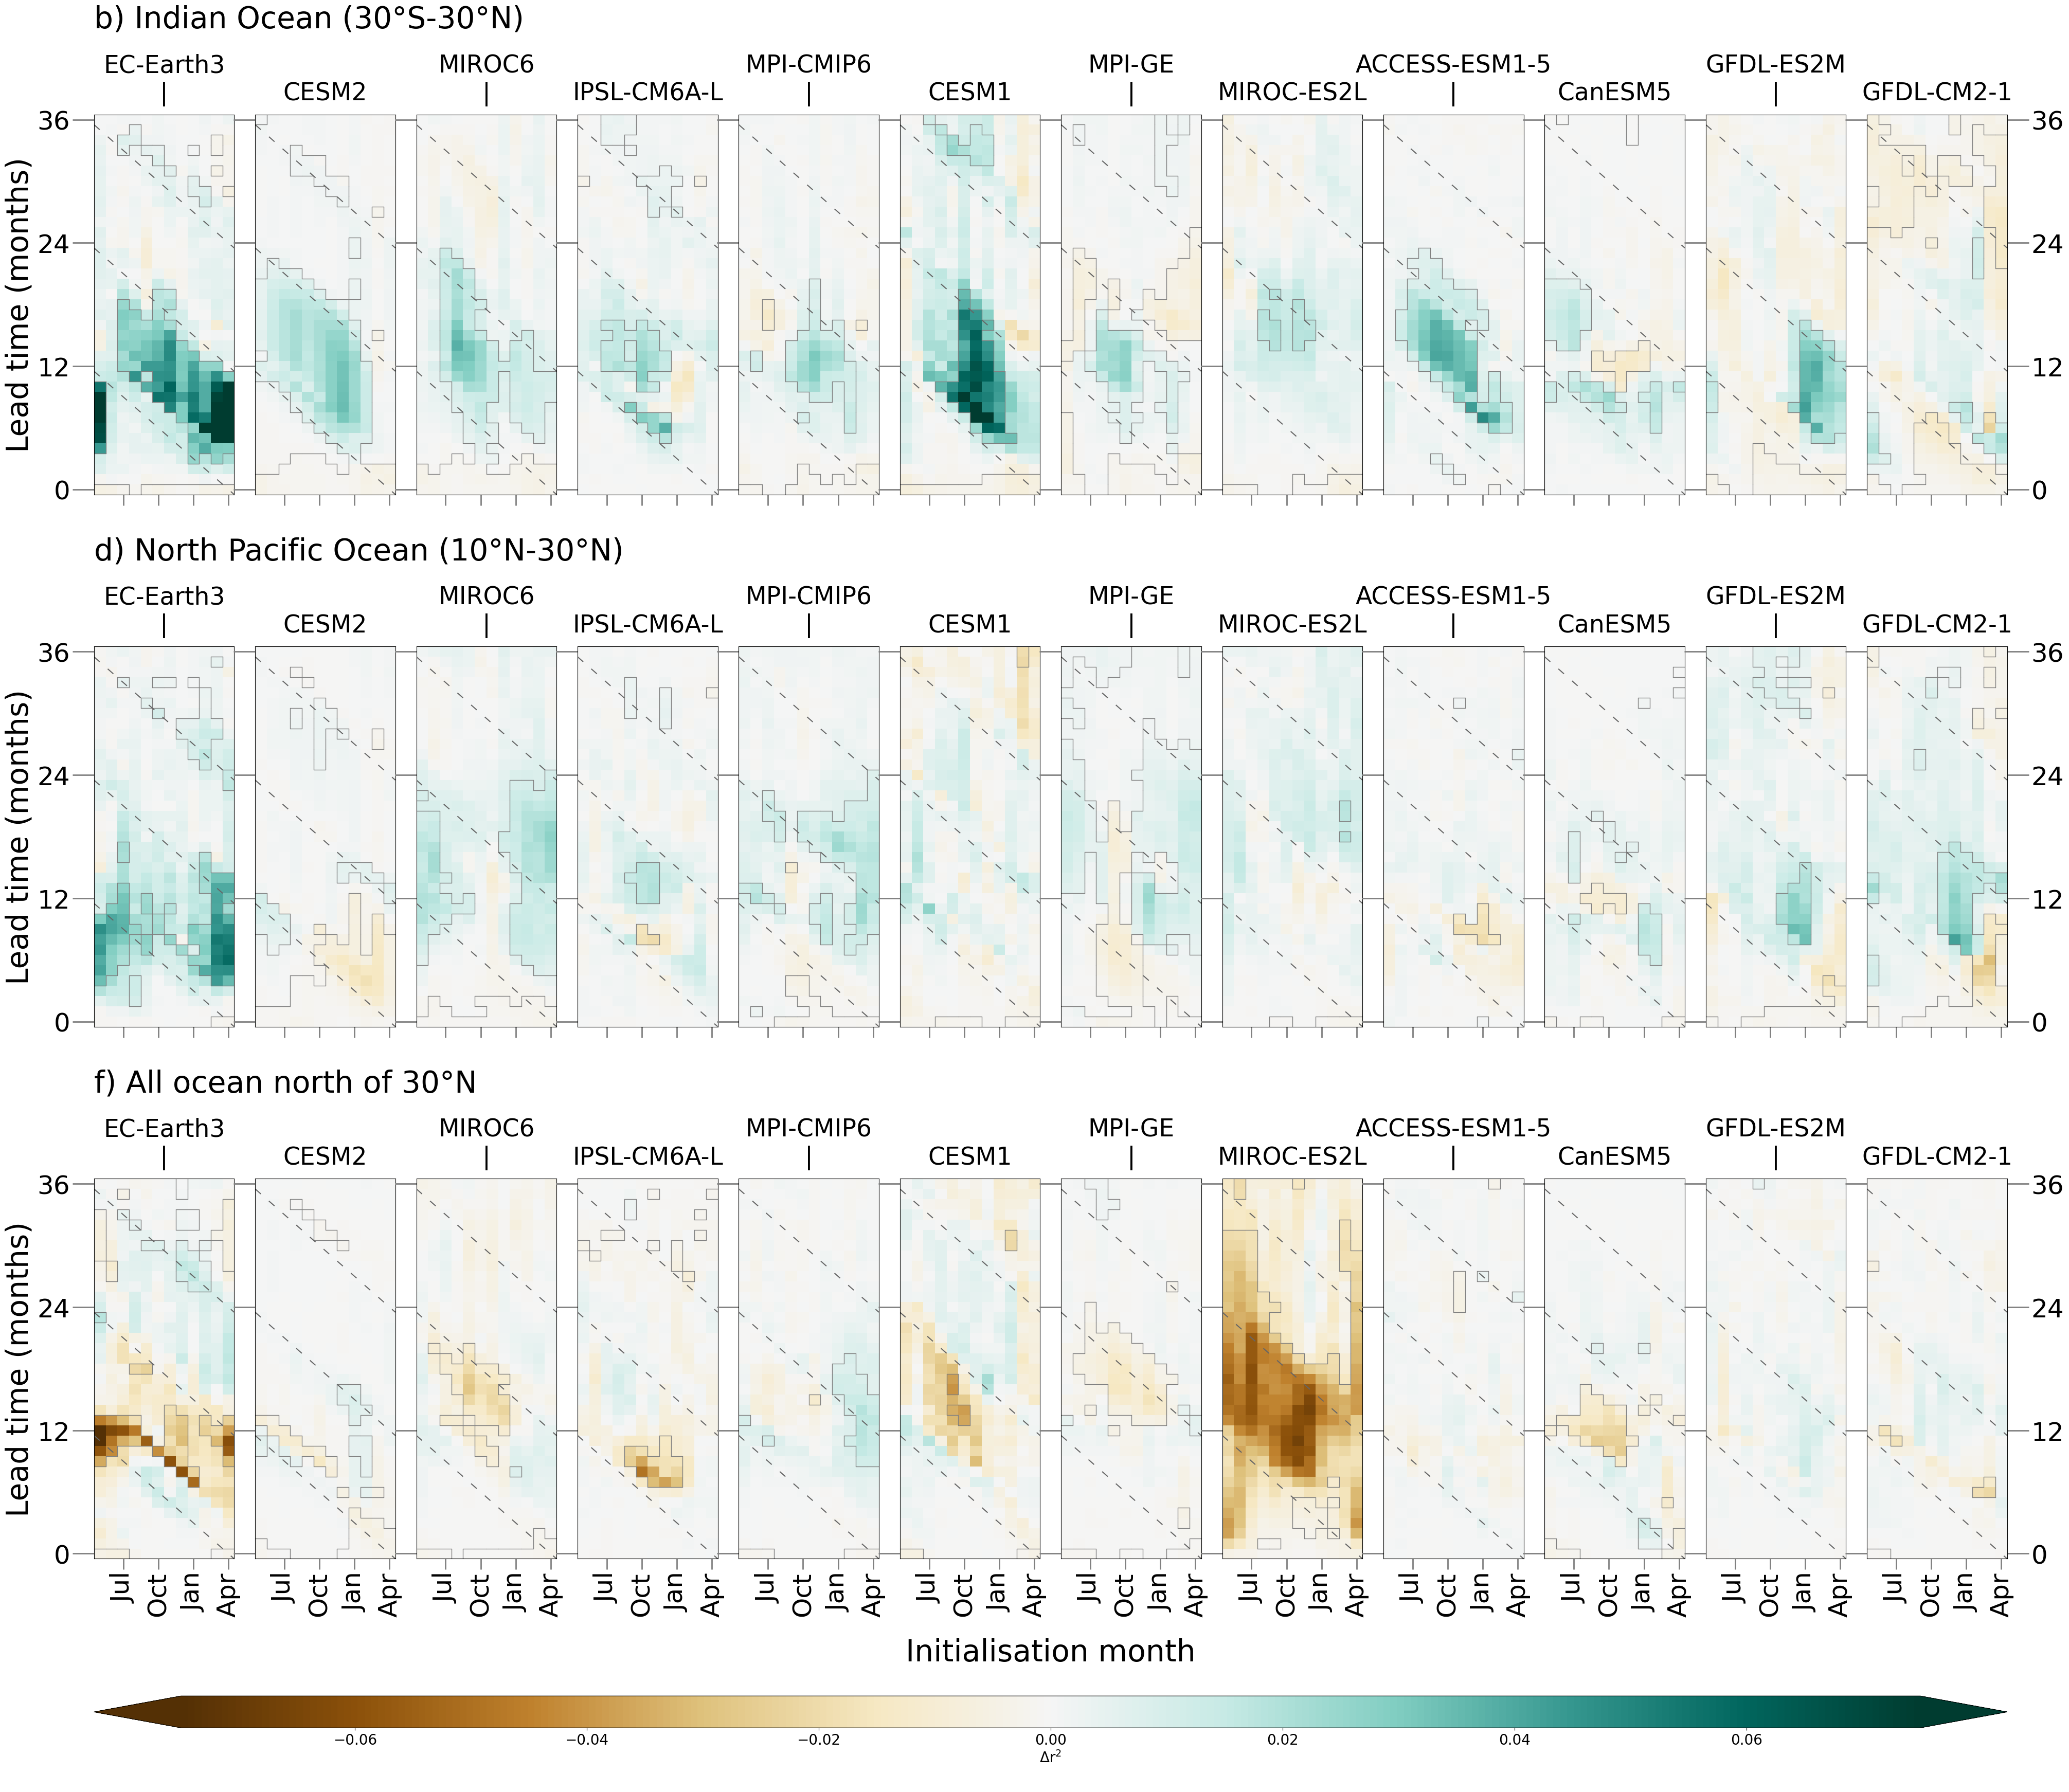

In [29]:
r_smile = xr.open_mfdataset(['/glade/work/jjeffree/results/area_corr/multiindex/NINO34_r/'+m+'.nc' 
                       for m in ('10P','10P30A','10P30I','10-30P','30-10P','10P30S','10P30N')]).load()
r_pace = xr.open_mfdataset(['/glade/work/jjeffree/results/area_corr/multiindex/NINO34_r/pacemaker_'+m+'.nc' 
                       for m in ('10P','10P30A','10P30I','10-30P','30-10P','10P30S','10P30N')]).load()

r = xr.merge((r_smile,r_pace))
fig, axs = plot_bunch_of_models(r,
                     start_mask = ('10P','10P','10P'),
                     later_mask = ('10P30I','10-30P','10P30N'),
                     models=model_keys[::-1],
                               titlesize=34)
plt.subplots_adjust(hspace=0.5)

fig.text(axs[0,0].get_position().x0,axs[0,0].get_position().y1+0.037,"b) Indian Ocean (30°S-30°N)",size=42,ha='left',va='bottom')
fig.text(axs[1,0].get_position().x0,axs[1,0].get_position().y1+0.037,"d) North Pacific Ocean (10°N-30°N)",size=42,ha='left',va='bottom')
fig.text(axs[2,0].get_position().x0,axs[2,0].get_position().y1+0.037,"f) All ocean north of 30°N",size=42,ha='left',va='bottom')
fig.text((axs[2,0].get_position().x0+axs[2,-1].get_position().x1)/2,axs[2,0].get_position().y0-0.05,"Initialisation month",size=42,ha='center',va='bottom')


plt.savefig('figures/poster_everything_2.pdf',bbox_inches='tight',pad_inches=0.4)

In [40]:
model_keys = np.array(([k for k in r.keys()]+[k for k in r_pace.keys()]))[np.arange(2,dtype=np.int32)]


In [38]:
np.array([[ 0,  9,  1,  2, 10, 11,  3,  4,  5,  6,  7,  8]],dtype=int)

array([[ 0,  9,  1,  2, 10, 11,  3,  4,  5,  6,  7,  8]])

/glade/derecho/scratch/jjeffree/tmp/ipykernel_6928/1118080746.py:10: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 1 Axes> than <Figure size 4800x4224 with 49 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(scatter,


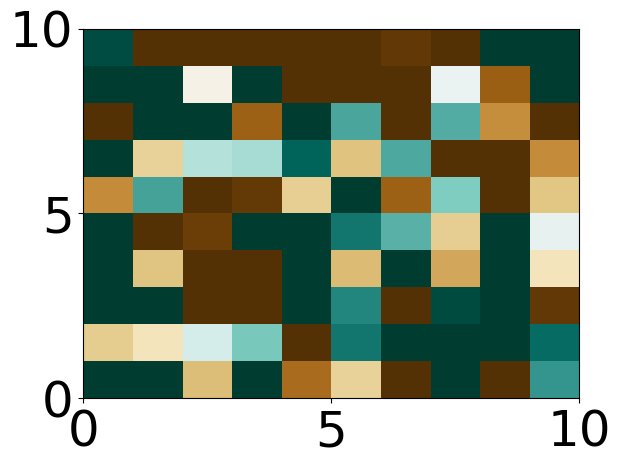

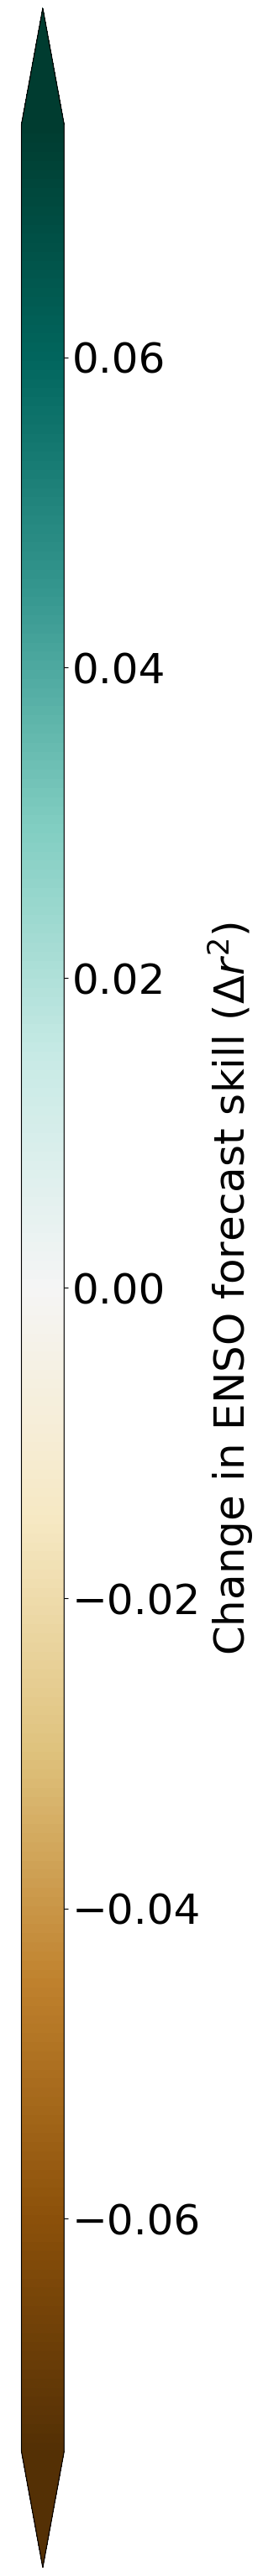

In [27]:
scatter = plt.pcolormesh(np.random.normal(0,0.1,(10,10)),
            cmap='BrBG',
                                 #marker='s',s=100,
                                 vmin=-0.075,vmax=0.075)

plt.figure(figsize=(2,12*1.1*3))
cb_axs = plt.axes()
cb_axs.axis('off')

cbar = fig.colorbar(scatter, 
                            ax=cb_axs,
                            orientation='vertical', 
                            fraction=1,
                             extend='both',
                            pad=0.1,
                            aspect=60,
                           )
cbar.ax.tick_params(labelsize=36)
cbar.set_label('Change in ENSO forecast skill ($\\Delta r^2$)', fontsize=36)
plt.savefig('figures/0075_colorbar.pdf',bbox_inches='tight',pad_inches=0.4)